In [123]:
# general
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

# torch
import torch
from torch import nn, optim
import torch.nn.functional as F

# scikit
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [43]:
# plots config
%matplotlib inline
%config InlineBackend.figure_format="retina"

palette = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set(style="whitegrid", palette="muted", font_scale=1.2)
sns.set_palette(sns.color_palette(palette=palette))

# seeding
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [44]:
df = pd.read_csv("./data/weather-australian/weatherAUS.csv")
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [45]:
# cols to use
cols = ["Rainfall", "Humidity3pm", "Pressure9am", "RainToday", "RainTomorrow"]
df = df[cols]
df

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.6,22.0,1007.7,No,No
1,0.0,25.0,1010.6,No,No
2,0.0,30.0,1007.6,No,No
3,0.0,16.0,1017.6,No,No
4,1.0,33.0,1010.8,No,No
...,...,...,...,...,...
145455,0.0,24.0,1024.6,No,No
145456,0.0,21.0,1023.5,No,No
145457,0.0,24.0,1021.0,No,No
145458,0.0,24.0,1019.4,No,No


In [46]:
# convert everything to numbers
df.RainToday.replace({"No": 0, "Yes": 1}, inplace=True)
df.RainTomorrow.replace({"No": 0, "Yes": 1}, inplace=True)
df

/tmp/ipykernel_112255/2482134236.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.RainToday.replace({"No": 0, "Yes": 1}, inplace=True)
/tmp/ipykernel_112255/2482134236.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.RainTomorrow.replace({"No": 0, "Yes": 1}, inplace=True)


,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.6,22.0,1007.7,0.0,0.0
1,0.0,25.0,1010.6,0.0,0.0
2,0.0,30.0,1007.6,0.0,0.0
3,0.0,16.0,1017.6,0.0,0.0
4,1.0,33.0,1010.8,0.0,0.0
...,...,...,...,...,...
145455,0.0,24.0,1024.6,0.0,0.0
145456,0.0,21.0,1023.5,0.0,0.0
145457,0.0,24.0,1021.0,0.0,0.0
145458,0.0,24.0,1019.4,0.0,0.0


In [47]:
# drop missing values
df = df.dropna(how="any")
df.shape

(124689, 5)

/home/luba/.local/share/virtualenvs/get-things-done-pytorch-AOPrClJF/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='RainTomorrow', ylabel='count'>

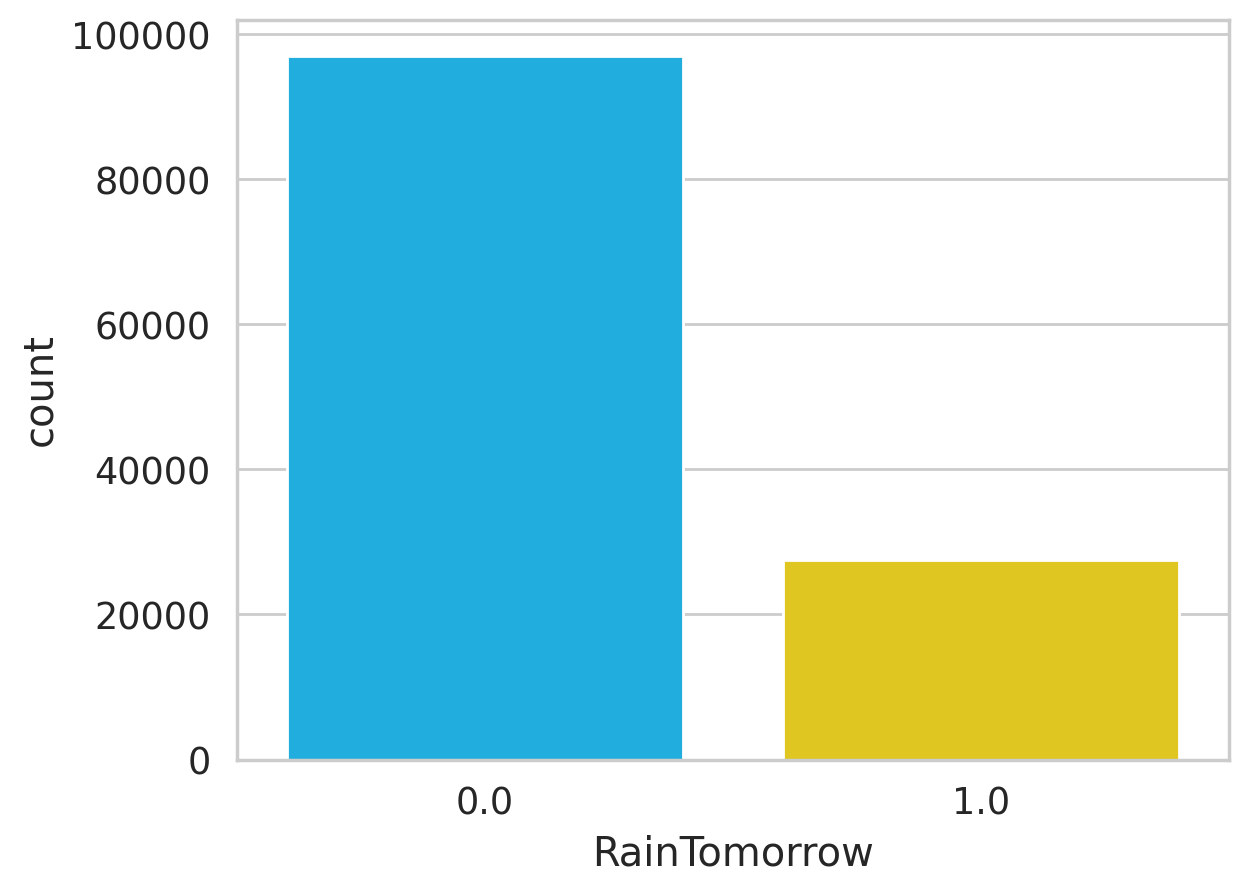

In [48]:
sns.countplot(df.RainTomorrow)

In [49]:
df.RainTomorrow.value_counts(normalize=True)

0.0    0.778762
1.0    0.221238
Name: RainTomorrow, dtype: float64

In [50]:
# will not handle umbalanced datasets
X = df[["Rainfall", "Humidity3pm", "RainToday", "Pressure9am"]]
y = df[["RainTomorrow"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [51]:
# passing to tensors
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

In [52]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([99751, 4]),
 torch.Size([24938, 4]),
 torch.Size([99751]),
 torch.Size([24938]))

In [53]:
# build a nn
class Net(nn.Module):
    def __init__(self, n_features) -> None:
        super(Net, self).__init__()
        self.feed_forward = nn.Sequential(
            nn.Linear(n_features, 5),
            nn.ReLU(),
            nn.Linear(5, 3),
            nn.ReLU(),
            nn.Linear(3, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        output = self.feed_forward(x)
        # output_probs = torch.sigmoid(output)
        return output

In [54]:
model = Net(X_train.shape[1])
model

Net(
  (feed_forward): Sequential(
    (0): Linear(in_features=4, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=3, bias=True)
    (3): ReLU()
    (4): Linear(in_features=3, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

(-1.5, 1.5)

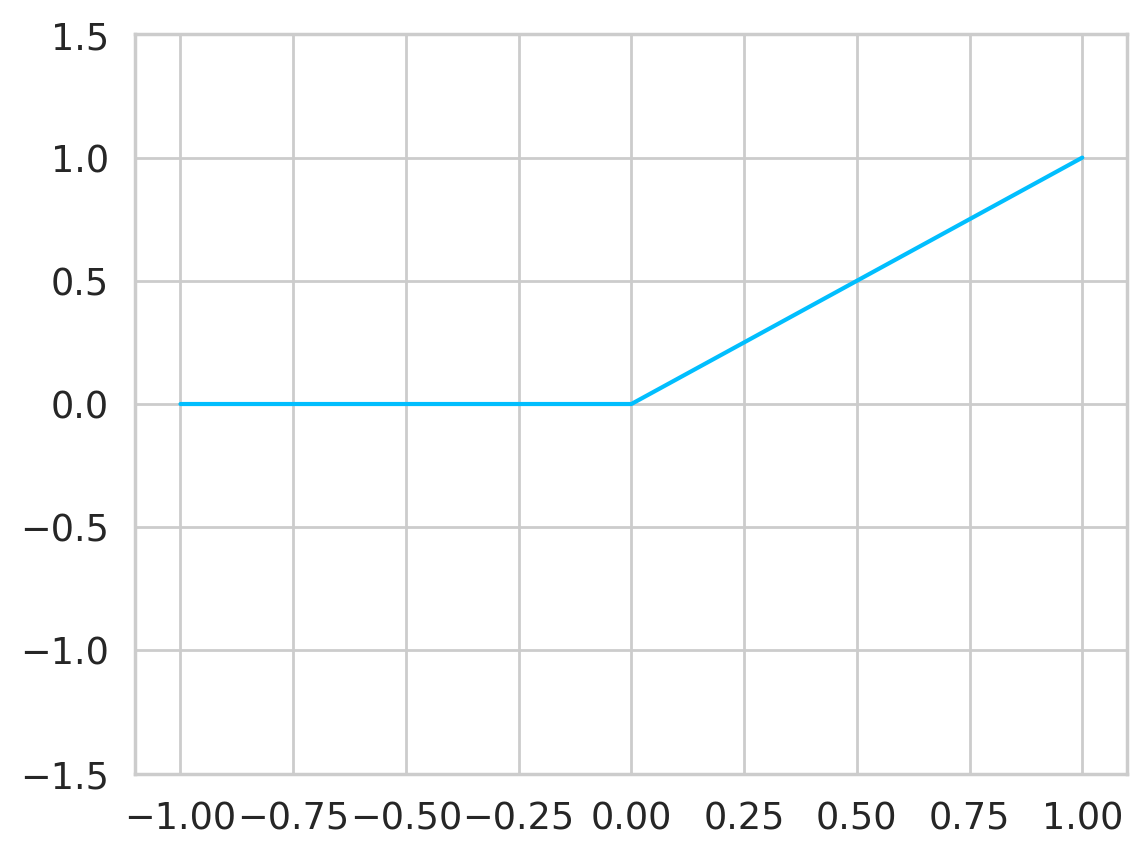

In [55]:
# visualizing ReLu
x = np.linspace(-1, 1, 5)
fx = F.relu(torch.linspace(-1, 1, steps=5)).numpy()

ax = plt.gca()
plt.plot(x, fx)
ax.set_ylim([-1.5, 1.5])


(-1.5, 1.5)

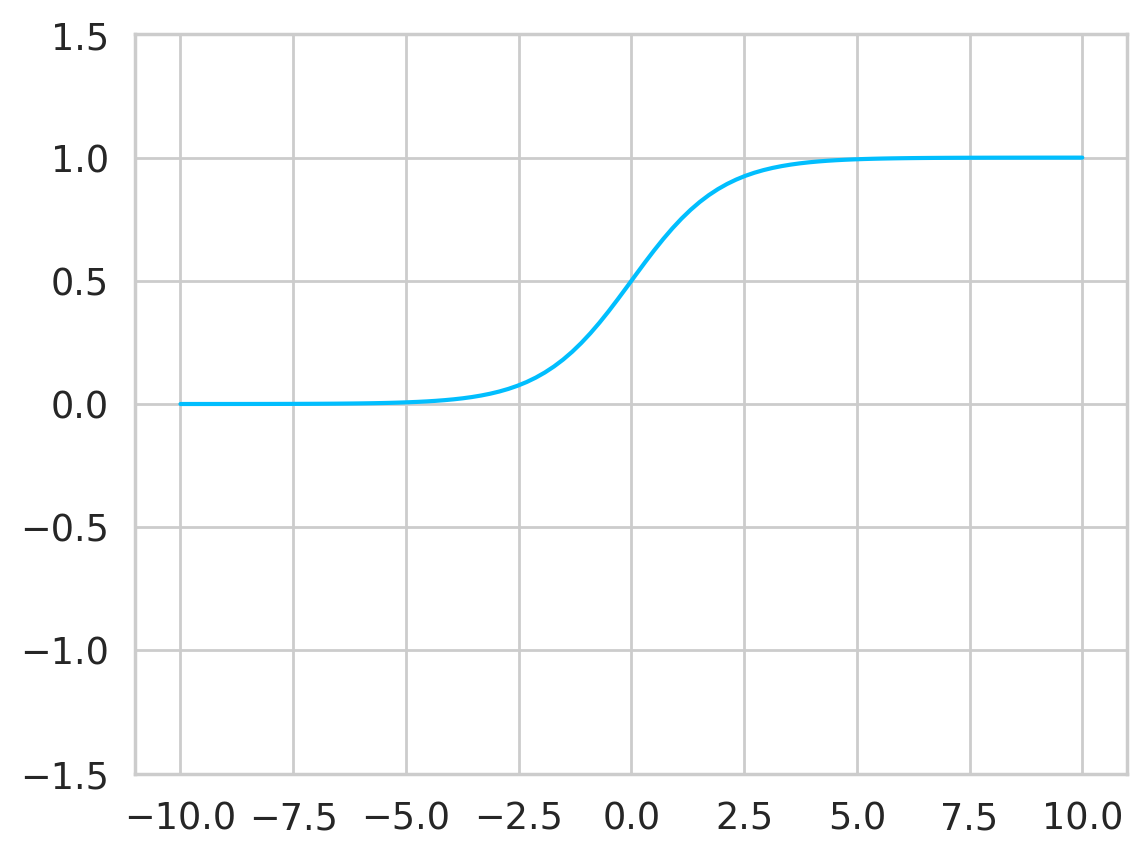

In [56]:
# visualizing sigmoid
ax = plt.gca()

plt.plot(
    np.linspace(-10, 10, 100),
    torch.sigmoid(torch.linspace(-10, 10, steps=100)).numpy()
)
ax.set_ylim([-1.5, 1.5])

In [57]:
# setting up our objective function: telling us
# how good the training is doing
criterion = nn.BCELoss()


The closer the value of the BCELoss get to zero, better!

In [58]:
# setting up the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [59]:
# choose the device to run your training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [60]:
# passing the objects to the correct device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)
model = model.to(device)
criterion = criterion.to(device)

In [61]:
# experimenting with this .ge method
tensors = torch.tensor([1, 0.4, 0.7], dtype=torch.float)
tensors.ge(.5).view(-1)

tensor([ True, False,  True])

In [62]:
# we still needing a evaluation metric
# to decide if our model is performing on 
# the overall training
def calculate_accuracy(y_true, y_pred):
    predicted = y_pred.ge(.5).view(-1)
    return (y_true == predicted).sum().float() / len(y_true)

def round_tensors(t, decimal_places=3):
    return round(t.item(), decimal_places)

In [63]:
# lets start the training
for epoch in range(1000):
    model = model.train()
    y_pred = model(X_train)

    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)

    model.eval()
    with torch.no_grad():
        train_acc = calculate_accuracy(y_train, y_pred)
        y_pred_test = model(X_test)
        y_pred_test = torch.squeeze(y_pred_test)
        test_loss = criterion(y_pred_test, y_test)
        test_acc = calculate_accuracy(y_test, y_pred_test)

    if epoch % 100 == 0:
        print("Epoch {}: train_loss {}, test_loss {}, train_acc {}, test_acc {}".format(epoch, train_loss, test_loss, train_acc, test_acc))

    train_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

Epoch 0: train_loss 2.512702226638794, test_loss 2.516558885574341, train_acc 0.7788794040679932, test_acc 0.7784906625747681
Epoch 100: train_loss 0.4570440351963043, test_loss 0.45828184485435486, train_acc 0.7924231290817261, test_acc 0.7927660346031189
Epoch 200: train_loss 0.43474334478378296, test_loss 0.4356240928173065, train_acc 0.8005734086036682, test_acc 0.8004250526428223
Epoch 300: train_loss 0.4205629527568817, test_loss 0.4211309552192688, train_acc 0.8135958313941956, test_acc 0.8151014447212219
Epoch 400: train_loss 0.41239798069000244, test_loss 0.41270914673805237, train_acc 0.8257160186767578, test_acc 0.8271713852882385
Epoch 500: train_loss 0.4079923629760742, test_loss 0.40810513496398926, train_acc 0.8310592770576477, test_acc 0.8317828178405762
Epoch 600: train_loss 0.405758798122406, test_loss 0.40572595596313477, train_acc 0.8331946134567261, test_acc 0.8345496654510498
Epoch 700: train_loss 0.40467941761016846, test_loss 0.40453994274139404, train_acc 0.833

In [64]:
# saving our model
MODEL_PATH = 'models/ch02/model.pt'

# to save model
model_to_save = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}

torch.save(model_to_save, MODEL_PATH)

In [65]:
MODEL_PATH = 'models/ch01/model.pt'
states = torch.load(MODEL_PATH, map_location=device)


In [122]:
# evaluate more than accuracy
# X_train = X_train.to(device)
new_model = Net(X_train.shape[1])
# new_model = new_model.to(device)

new_model.load_state_dict(states["model_state_dict"])
new_model.to(device)

y_pred = new_model(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu().to(torch.int32)
y_test = y_test.ge(.5).cpu().to(torch.int32)

print(classification_report(y_test, y_pred, target_names=["No Rain", "Raining"]))

              precision    recall  f1-score   support

     No Rain       0.85      0.96      0.90     19413
     Raining       0.74      0.40      0.52      5525

    accuracy                           0.84     24938
   macro avg       0.80      0.68      0.71     24938
weighted avg       0.83      0.84      0.82     24938



Text(0.5, 16.049999999999997, 'Predicted label')

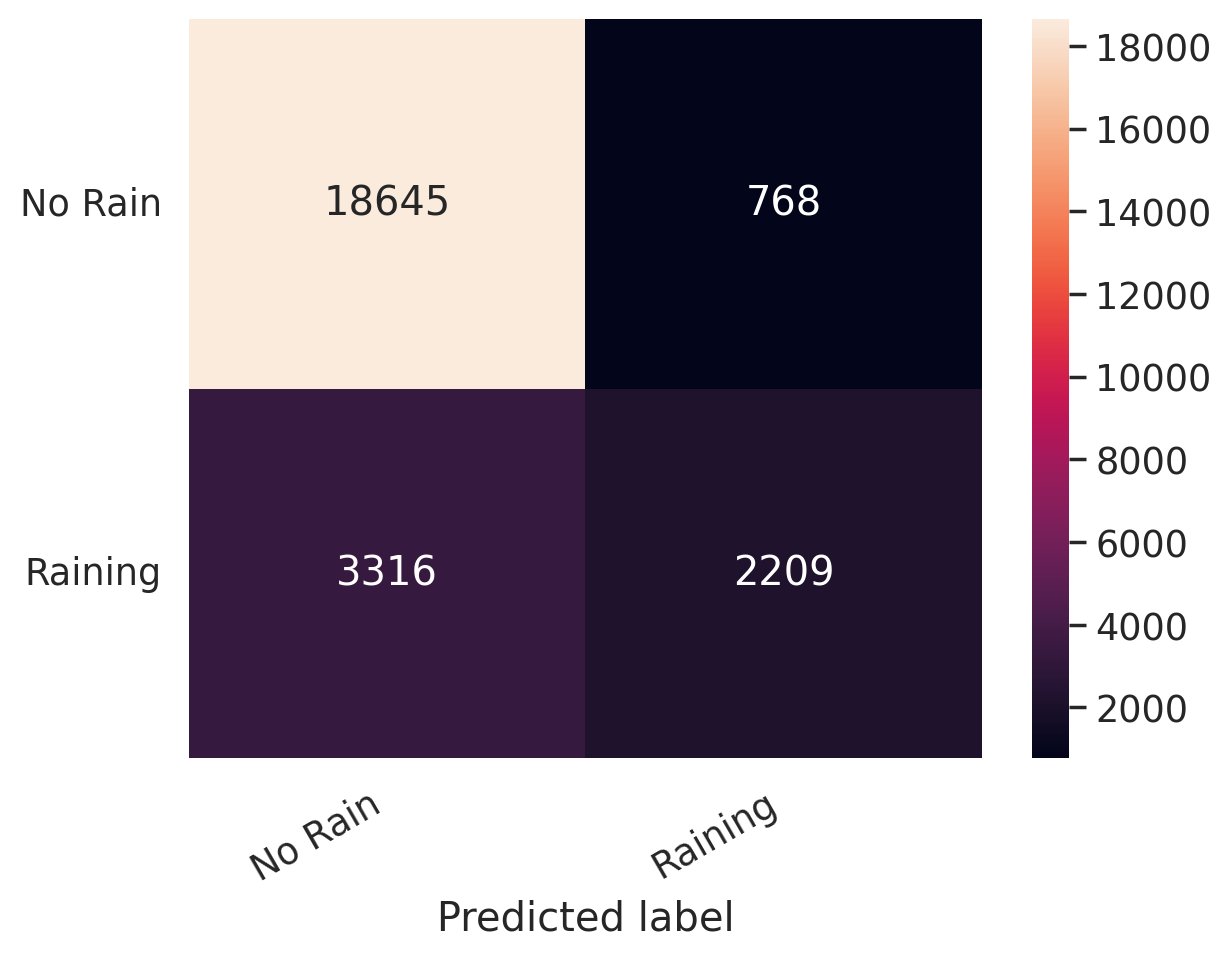

In [127]:
classes = ["No Rain", "Raining"]
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

hmap = sns.heatmap(df_cm, annot=True, fmt='d')
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha="right")
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha="right")
plt.xlabel('True label')
plt.xlabel('Predicted label')